In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Concatenate, Reshape, Input, Conv1D, Flatten, MaxPooling1D
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  480 non-null    float64
 1   ip         480 non-null    float64
dtypes: float64(2)
memory usage: 11.2 KB


In [7]:
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,46.0471
1980-02-01,66.9,47.1305
1980-03-01,56.5,47.6433
1980-04-01,52.7,46.2537
1980-05-01,51.7,44.9161


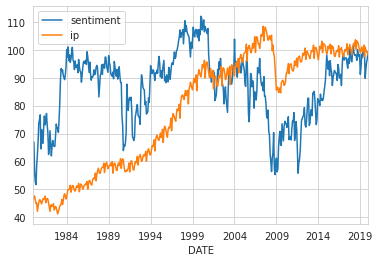

In [83]:
# 이 2개의 시계열을 한번에 모델링 해서
# 2개의 시계열을 각각 예측
df.plot()

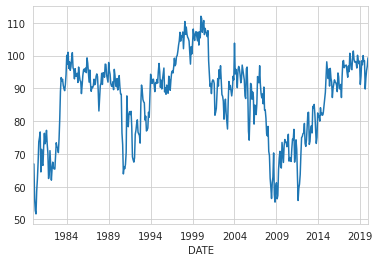

In [84]:
df1 = df['sentiment']
df1.plot()

In [85]:
df1

DATE
1980-01-01    67.0
1980-02-01    66.9
1980-03-01    56.5
1980-04-01    52.7
1980-05-01    51.7
              ... 
2019-08-01    89.8
2019-09-01    93.2
2019-10-01    95.5
2019-11-01    96.8
2019-12-01    99.3
Name: sentiment, Length: 480, dtype: float64

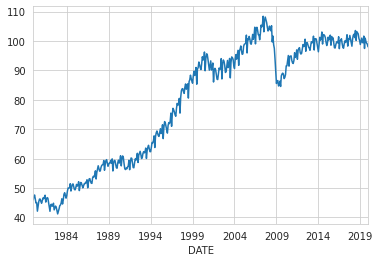

In [86]:
df2 = df['ip']
df2.plot()

In [87]:
df2

DATE
1980-01-01     46.0471
1980-02-01     47.1305
1980-03-01     47.6433
1980-04-01     46.2537
1980-05-01     44.9161
                ...   
2019-08-01    100.9667
2019-09-01     99.8213
2019-10-01     99.2675
2019-11-01     98.9537
2019-12-01     98.0413
Name: ip, Length: 480, dtype: float64

In [88]:
df2.reset_index().rename(columns={"index": "date"})

,DATE,ip
0,1980-01-01,46.0471
1,1980-02-01,47.1305
2,1980-03-01,47.6433
3,1980-04-01,46.2537
4,1980-05-01,44.9161
...,...,...
475,2019-08-01,100.9667
476,2019-09-01,99.8213
477,2019-10-01,99.2675
478,2019-11-01,98.9537


In [91]:
df1

DATE
1980-01-01    67.0
1980-02-01    66.9
1980-03-01    56.5
1980-04-01    52.7
1980-05-01    51.7
              ... 
2019-08-01    89.8
2019-09-01    93.2
2019-10-01    95.5
2019-11-01    96.8
2019-12-01    99.3
Name: sentiment, Length: 480, dtype: float64

In [92]:
df1.reset_index().rename(columns={"index": "id"})

,DATE,sentiment
0,1980-01-01,67.0
1,1980-02-01,66.9
2,1980-03-01,56.5
3,1980-04-01,52.7
4,1980-05-01,51.7
...,...,...
475,2019-08-01,89.8
476,2019-09-01,93.2
477,2019-10-01,95.5
478,2019-11-01,96.8


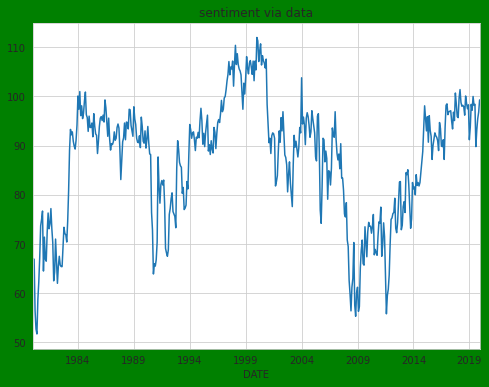

In [93]:
plt.figure(figsize=(8,6), facecolor='green')
df1.plot()
plt.title("sentiment via data")
plt.show()

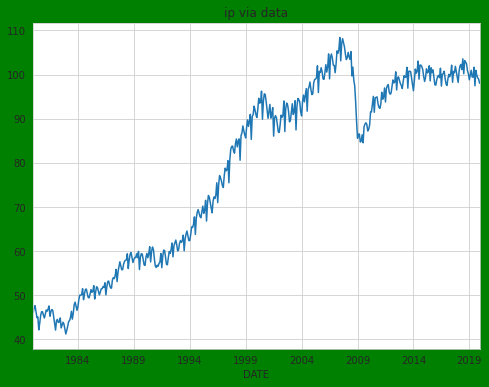

In [94]:
plt.figure(figsize=(8,6), facecolor='green')
df2.plot()
plt.title("ip via data")
plt.show()

<class 'matplotlib.axes._subplots.AxesSubplot'>


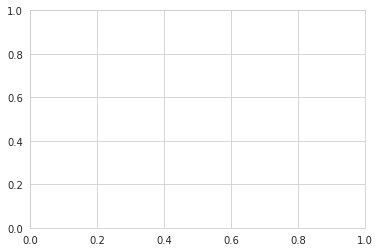

In [95]:
ax = plt.axes()
print(type(ax))

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>


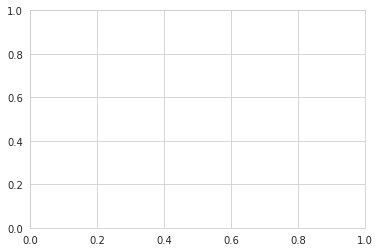

In [96]:
### pyplot에서 설정된 Figure와 Axes 객체를 함께 가져오기 

fig, ax = plt.subplots()
print(type(fig), type(ax))

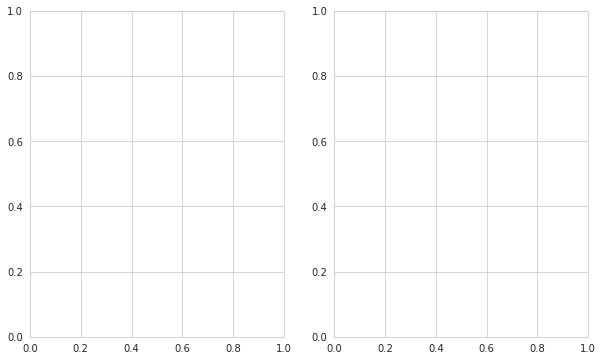

In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

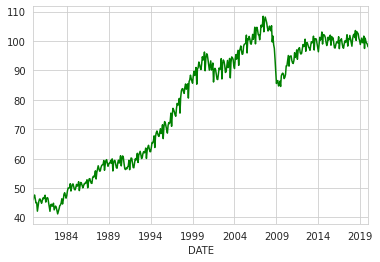

In [98]:
df2.plot(color='green')

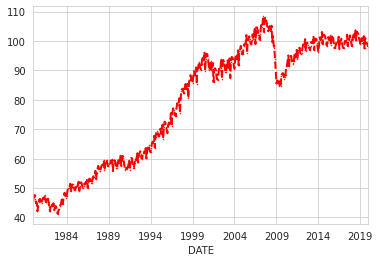

In [99]:
df2.plot(color='red', marker='o', linestyle='dashed', linewidth=2, markersize=0.5)

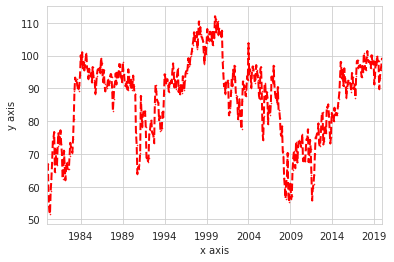

In [100]:
df1.plot(color='red', marker='o', linestyle='dashed', linewidth=2, markersize=0.5)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

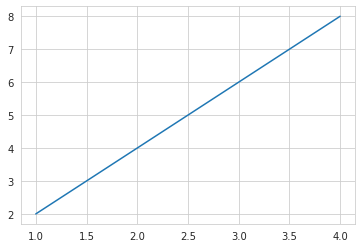

In [101]:
import pandas as pd 
x_value = [1, 2, 3, 4]
y_value = [2, 4, 6, 8]
x_value = np.array([1, 2, 3, 4])
y_value = np.array([2, 4, 6, 8])

# 입력값으로 파이썬 리스트, numpy array 가능. x축값과 y축값은 모두 같은 크기를 가져야 함. 

df3 = pd.DataFrame({'x_value':[1, 2, 3, 4],
                   'y_value':[2, 4, 6, 8]})

# 입력값으로 pandas Series 및 DataFrame도 가능. 
plt.plot(df3['x_value'], df3['y_value'])

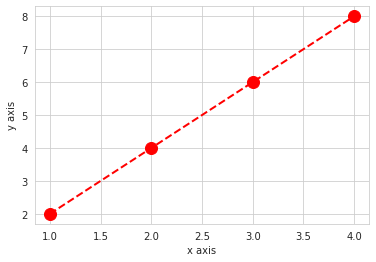

In [102]:
## x축, y축에 축명을 텍스트로 할당. xlabel, ylabel 적용
plt.plot(x_value, y_value, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

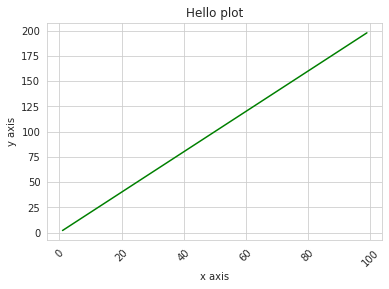

In [103]:
# x축, y축 틱값을 표현을 회전해서 보여줌. x축값이 문자열이고 많은 tick값이 있을 때 적용함
x_value = np.arange(1, 100)
y_value = 2*x_value

plt.plot(x_value, y_value, color='green')
plt.xlabel('x axis')
plt.ylabel('y axis')

plt.xticks(rotation=45)
#plt.yticks(rotation=45)

plt.title('Hello plot')
plt.show()

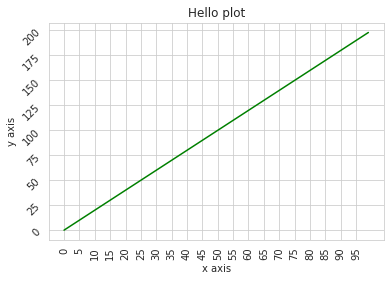

In [104]:
x_value = np.arange(0, 100)
y_value = 2*x_value

plt.plot(x_value, y_value, color='green') # label='time' => 범례 설정
plt.xlabel('x axis')
plt.ylabel('y axis')

plt.xticks(ticks=np.arange(0, 100, 5), rotation=90)
plt.yticks(rotation=45)

## xlim()은 x축값을 제한하고, ylim()은 y축값을 제한
# x축값을 0에서 50으로, y축값을 0에서 100으로 제한. 
# plt.xlim(0, 50)
# plt.ylim(0, 100)

#-----
# plt.legend()
plt.title('Hello plot')
plt.show()

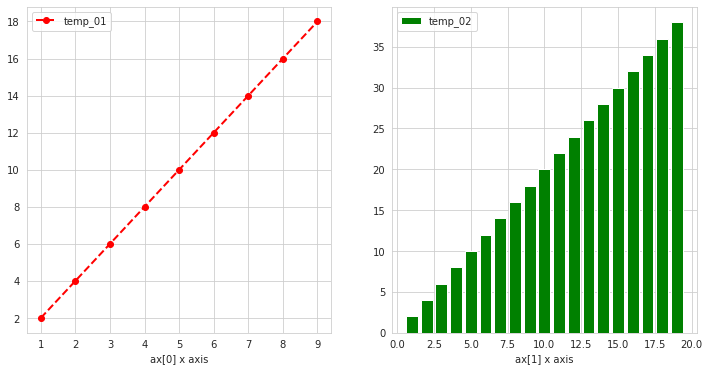

In [108]:
x_value_01 = np.arange(1, 10)
x_value_02 = np.arange(1, 20)
y_value_01 = 2 * x_value_01
y_value_02 = 2 * x_value_02

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(x_value_01, y_value_01, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6, label='temp_01')
ax[1].bar(x_value_02, y_value_02, color='green', label='temp_02')

ax[0].set_xlabel('ax[0] x axis')
ax[1].set_xlabel('ax[1] x axis')

ax[0].legend()
ax[1].legend() 

#plt.legend()
plt.show()

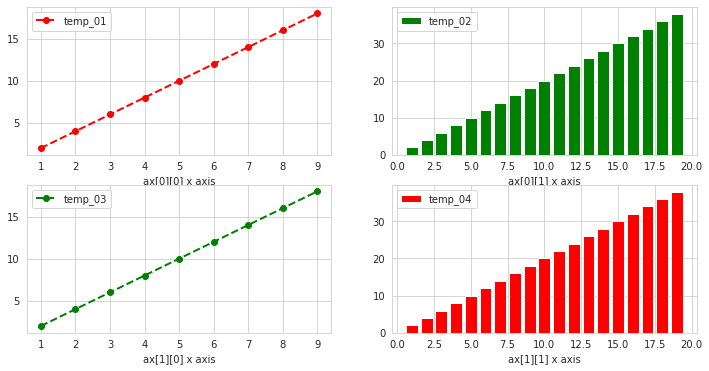

In [109]:
x_value_01 = np.arange(1, 10)
x_value_02 = np.arange(1, 20)
y_value_01 = 2 * x_value_01
y_value_02 = 2 * x_value_02

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

ax[0][0].plot(x_value_01, y_value_01, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6, label='temp_01')
ax[0][1].bar(x_value_02, y_value_02, color='green', label='temp_02')
ax[1][0].plot(x_value_01, y_value_01, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6, label='temp_03')
ax[1][1].bar(x_value_02, y_value_02, color='red', label='temp_04')

ax[0][0].set_xlabel('ax[0][0] x axis')
ax[0][1].set_xlabel('ax[0][1] x axis')
ax[1][0].set_xlabel('ax[1][0] x axis')
ax[1][1].set_xlabel('ax[1][1] x axis')

ax[0][0].legend()
ax[0][1].legend() 
ax[1][0].legend()
ax[1][1].legend() 

#plt.legend()
plt.show()